In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from proofreader.utils.io import read_cremi_volume, from_h5
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import IPython

def view_volume(volume, fig_size=6.5):
    length = volume.shape[0]

    # set up
    fig = plt.figure()
    fig.set_size_inches(fig_size, fig_size)
    axes = fig.add_subplot()
    hfig = display(fig, display_id=True)

    # display
    for i in range(length):
        axes.imshow(volume[i], cmap='gray', interpolation='none',
                    filternorm=False, resample=False)
        fig.canvas.draw()
        hfig.update(fig)
        if i != length-1:
            plt.cla()
    # clean up
    IPython.display.clear_output()


In [3]:
def least_sq(data):
    # Calculate the mean of the points, i.e. the 'center' of the cloud
    datamean = data.mean(axis=0)

    # Do an SVD on the mean-centered data.
    uu, dd, vv = np.linalg.svd(data - datamean)

    # Now vv[0] contains the first principal component, i.e. the direction
    # vector of the 'best fit' line in the least squares sense.

    unit = vv[0]
    intercept = datamean
    return unit, intercept

def least_sq_solve_for_z(vec,off,z):
    s = (z - off[0]) / vec[0]
    return vec*s + off


In [4]:
from proofreader.utils.all import clamp

def test_success(vol, c, num_slices, radius, inter_slices, context_slices=10):

    margin = 1 # number of slices that must be left on top after droping slices
    top_c = c
    (sz, sy, sx) = vol.shape
    all_res = {}

    # Find min and max z slice on which c occurs #
    for i in range(sz):
        if c in vol[i]:
            zmin = i
            break
    for i in reversed(range(sz)):
        if c in vol[i]:
            zmax = i
            break
    assert zmax - zmin >= num_slices + 2 , f'zspan of neurite must be at least 2 slices bigger than num_slices to drop, zspan:{zmax - zmin}, num_slices:{num_slices}'
    # the drop can start at the end of the top nerutie for negative examples
    # but should start earlier such that there is some bottom fragment for postive examples
    z_max_range = zmax-margin-num_slices+1
    drop_start = random.randint(zmin+margin, z_max_range) # margin not needed on bottom
    drop_end = min(drop_start+num_slices, vol.shape[0]) # take min to ensure there is some bottom vol
    top_z_len = min(context_slices, drop_start-zmin) 
    bot_z_len = min(context_slices, sz-drop_end) 

    # Alloc final vol, we dont know how large it will be in y and x but we know max z #
    mz = num_slices + top_z_len + bot_z_len
    final_vol = np.zeros((mz, sy, sx), dtype='uint')

    # Build top section #
    top_vol_section = final_vol[0:top_z_len]
    top_vol_section[vol[drop_start-top_z_len:drop_start] == top_c] = top_c

    # Do connected component relabeling to ensure only one fragment on top #
    top_vol_section_relabeled = cc3d.connected_components(top_vol_section)
    top_classes_relabeled = list(np.unique(top_vol_section_relabeled[-1])) # must select from top border slice
    top_classes_relabeled = list_remove(top_classes_relabeled, 0)

    if len(top_classes_relabeled) == 0:
        print('encountered error, dumping')
        print('zmin, zmax: ', zmin, zmax)
        print('top_c', top_c)
        print('drop range: ', drop_start, drop_end )
        print('top, bot z_len: ', top_z_len, bot_z_len )

    relabeled_top_c = random.choice(top_classes_relabeled) # select new top class from relabeled top section
    top_vol_section_relabeled[top_vol_section_relabeled != relabeled_top_c] = 0

    def assess_method(method_bot_border, method=''):
        # view_segmentation([bot_border])
        bot_classes, counts = get_classes_sorted_by_volume(method_bot_border, reverse=True, return_counts=True)
        if len(bot_classes) == 1:
            print('encountered error, dumping')
            print(method)
            # print('mins, maxs', arg_where_range(vol==top_c))
            print('top_c', top_c)
            print('drop range: ', drop_start, drop_end )
            print('top, bot z_len: ', top_z_len, bot_z_len )

        assert bot_classes[0] == 0, 'most numerous should be zero'
        bot_classes, counts = bot_classes[1:], counts[1:]
        
        # does the true neurite occur?
        true_occur = top_c in bot_classes
        # how many total classes occur?
        num_classes = len(bot_classes)
        # percent vol of true
        if true_occur:
            vol = counts[top_c == bot_classes]
            total = np.sum(counts)
            percent = vol / total
            percent = percent[0]
            is_max = top_c == bot_classes[np.argmax(counts)]
        else:
            is_max = False
            percent = 0
        return true_occur, num_classes, is_max, percent 

    #############
    ## METHODS ##
    #############

    ## PROJECT ACROSS THEN L2 RADIUS ##
    # Get midpoint of neurite on 2D top cross section, #
    top_border = top_vol_section_relabeled[-1]
    mins, maxs = arg_where_range(top_border == relabeled_top_c) # use the relabeled top section
    mp_y, mp_x = [(mi+ma)//2 for mi,ma in zip(mins,maxs)] # midpoint

    # Find all neurites with distnce D from that point on bottom cross section #
    bot_border = vol[drop_end].copy() # need copy because we zero
    mask = circular_mask(bot_border.shape[0], bot_border.shape[1], center=(mp_x, mp_y), radius=radius)
    bot_border[~mask] = 0
    res = assess_method(bot_border, method='MIDPOINT_RADIUS')
    all_res['MIDPOINT_RADIUS'] = res

    ## APPLY CROSS-SECTION ACROSS ##
    bot_border = vol[drop_end].copy()
    bot_border[top_border != relabeled_top_c] = 0

    res = assess_method(bot_border, method='MIDPOINT_CROSS-SECTION')
    all_res['MIDPOINT_CROSS-SECTION'] = res

    ## INTERPOLATE MP THEN RADIUS ##
    # we need to do crop_where again in case we lost some during connected component
    mins, maxs = arg_where_range(top_vol_section_relabeled == relabeled_top_c) 
    num_points = min(inter_slices,maxs[0]-mins[0]+1)
    midpoints = []
    for i in range(num_points):
        section = top_vol_section_relabeled[-(i+1)]
        mins, maxs = arg_where_range(section == relabeled_top_c) # use the relabeled top section
        mp_y, mp_x = [(mi+ma)//2 for mi,ma in zip(mins,maxs)] # midpoint
        midpoints.append([drop_start-i-1, mp_y, mp_x])


    midpts = np.array(midpoints)
    vec, off = least_sq(midpts)
    (proj_z, proj_y, proj_x) = least_sq_solve_for_z(vec, off, drop_end)
    proj_y, proj_x = int(clamp(proj_y, 0, sy)), int(clamp(proj_x, 0, sx))

    # Find all neurites with distnce D from that point on bottom cross section #
    bot_border = vol[drop_end].copy() # need copy because we zero
    mask = circular_mask(bot_border.shape[0], bot_border.shape[1], center=(proj_x, proj_y), radius=radius)
    bot_border[~mask] = 0

    res = assess_method(bot_border, method='INTERPOLATE_RADIUS')
    all_res['INTERPOLATE_RADIUS'] = res


    ## INTERPOLATE MP THEN CROSS-SECTION ##
    midpoints = []
    for i in range(num_points):
        section = top_vol_section_relabeled[-(i+1)]
        mins, maxs = arg_where_range(section == relabeled_top_c) # use the relabeled top section
        mp_y, mp_x = [(mi+ma)//2 for mi,ma in zip(mins,maxs)] # midpoint
        midpoints.append([drop_start-i-1, mp_y, mp_x])


    midpts = np.array(midpoints)
    vec, off = least_sq(midpts)
    (proj_z, proj_y, proj_x) = least_sq_solve_for_z(vec, off, drop_end)
    proj_y, proj_x = int(clamp(proj_y, 0, sy)), int(clamp(proj_x, 0, sx))

    top_border = top_vol_section_relabeled[-1]
    bot_border = vol[drop_end].copy() # need copy because we zero
    mins, maxs = arg_where_range(top_border == relabeled_top_c) # use the relabeled top section
    top_border = crop_where(top_border, top_border == relabeled_top_c)
    shift_y_a, shift_y_b = split_int(maxs[0]-mins[0]+1)
    shift_x_a, shift_x_b = split_int(maxs[1]-mins[1]+1)
    x_a, x_b = proj_x-shift_x_a, proj_x+shift_x_b
    y_a, y_b = proj_y-shift_y_a, proj_y+shift_y_b
    if x_a < 0:
        top_border = top_border[:, -1*x_a:]
        x_a = 0
    if y_a < 0:
        top_border = top_border[-1*y_a:]
        y_a = 0
    if x_b > sx:
        top_border = top_border[:, :-1*(x_b-sx)]
        x_b = sx
    if y_b > sy:
        top_border = top_border[:-1*(y_b-sy)]
        y_b = sy

    bot_border_sec = bot_border[y_a:y_b, x_a:x_b]
    bot_border[:y_a] = 0
    bot_border[:,:x_a] = 0
    bot_border[y_b:] = 0
    bot_border[:,x_b:] = 0
    bot_border_sec[top_border != relabeled_top_c] = 0

    res = assess_method(bot_border, method='INTERPOLATE_CROSS-SECTION')
    all_res['INTERPOLATE_CROSS-SECTION'] = res


    return all_res

In [ ]:
vol = trueC.copy()

In [ ]:
num_slices = 3
classes_z = get_classes_which_zspan_at_least(vol, num_slices+2)
classes_vol = get_classes_with_at_least_volume(vol, 400)
classes = list(set(classes_z) & set(classes_vol))
print(f'{len(classes)}/{len(np.unique(vol))}')

In [ ]:
from pprint import pprint

init = {'total_occur':0, 'avg_classes_when_occur':0, 'total_max':0, 'avg_percent_when_occur':0 }
classes = list(classes)
random.shuffle(classes)
number_examples = min(500,len(classes))
radius = 64
inter_slices = 2
all_total = {}
for i in range(number_examples):
    c = classes[i]  
    all_res = test_success(vol, c, num_slices=num_slices, radius=radius, inter_slices=inter_slices)

    for key, value in all_res.items(): 
        true_occur, num_classes, is_max, percent  = value
        if i == 0:
            all_total[key] = init.copy()
        totals = all_total[key]
        if true_occur:
            totals['total_occur'] += 1
            totals['avg_classes_when_occur'] += num_classes
            totals['avg_percent_when_occur'] += percent
        if is_max:
            totals['total_max'] += 1
    
    print('.', end='')

for key, value in all_res.items(): 
    totals = all_total[key]
    totals['avg_classes_when_occur'] /= totals['total_occur'] 
    totals['avg_percent_when_occur'] /= totals['total_occur'] 
    totals['avg_occur'] = totals['total_occur'] / number_examples
    totals['avg_max'] = totals['total_max']  / number_examples

print(f'\nnum slices: {num_slices} num examples: {number_examples}, radius {radius}, inter_slices {inter_slices}')
pprint(all_total)

In [2]:
from proofreader.data.cremi import prepare_cremi_vols

train_vols, test_vols = prepare_cremi_vols('../../dataset/cremi')

In [10]:
from proofreader.data.splitter import SplitterDataset

num_slices = [1, 4]
radius = 96
context_slices = 6
num_points = 1024

dataset = SplitterDataset(train_vols, num_slices, radius, context_slices, num_points=num_points, torch=False, open_vol=True, normalize=True, return_vol=True, verbose=True)
print(len(dataset))

3534


1, vol: 2, c: 369
num_slices: 4, drop: [9, 13]
not enough points, need 1024, have 618, replace sampling to fix
pc shape: (3, 1024), vol shape: (11, 27, 116)
-0.5 0.5


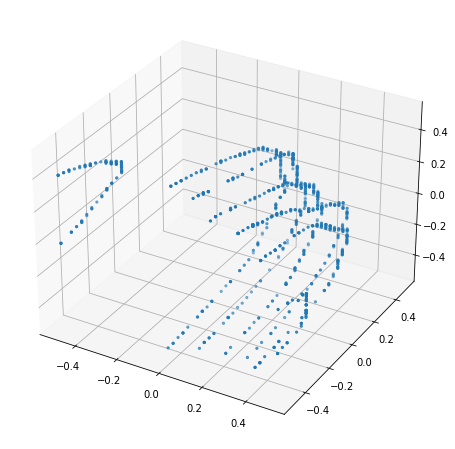

0, vol: 0, c: 523
num_slices: 1, drop: [3, 4]
not enough points, need 1024, have 303, replace sampling to fix
pc shape: (3, 1024), vol shape: (5, 91, 98)
-0.5 0.5


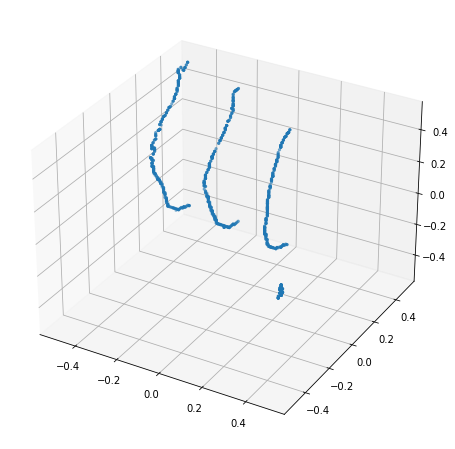

0, vol: 2, c: 795
num_slices: 4, drop: [43, 47]
pc shape: (3, 1024), vol shape: (16, 213, 379)
-0.5 0.5


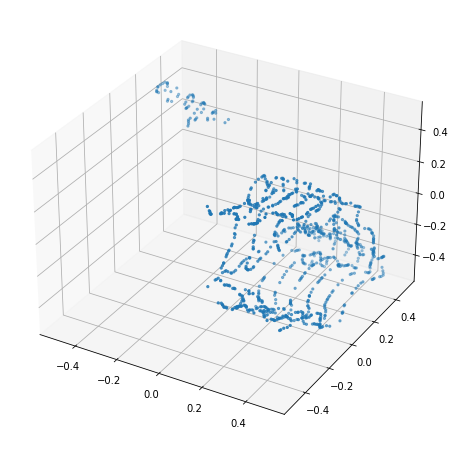

0, vol: 2, c: 1782
num_slices: 1, drop: [106, 106]
pc shape: (3, 1024), vol shape: (8, 215, 456)
-0.5 0.5


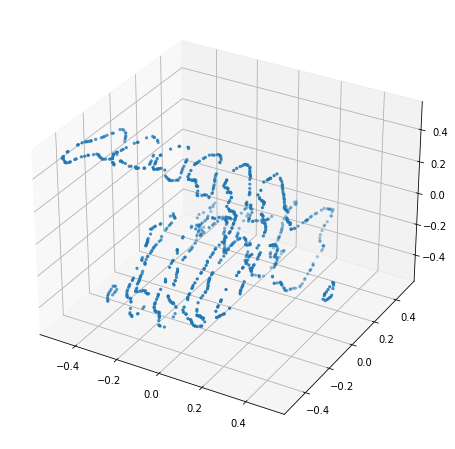

1, vol: 1, c: 1271
num_slices: 1, drop: [91, 92]
not enough points, need 1024, have 858, replace sampling to fix
pc shape: (3, 1024), vol shape: (9, 49, 101)
-0.5 0.5


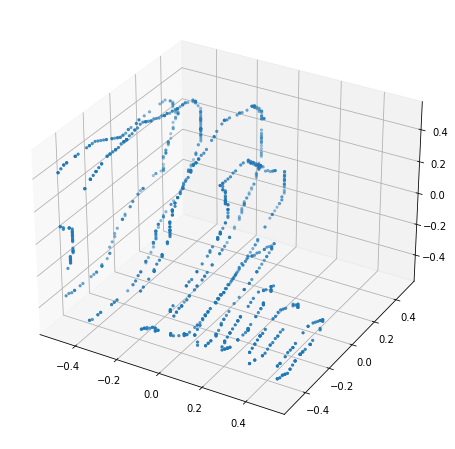

1, vol: 2, c: 1052
num_slices: 3, drop: [51, 54]
pc shape: (3, 1024), vol shape: (11, 99, 157)
-0.5 0.5


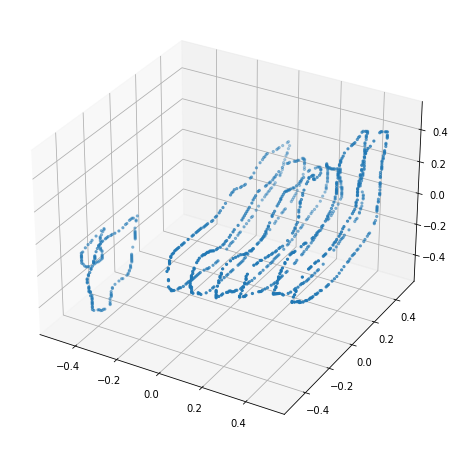

1, vol: 1, c: 1212
num_slices: 4, drop: [87, 91]
pc shape: (3, 1024), vol shape: (13, 55, 139)
-0.5 0.5


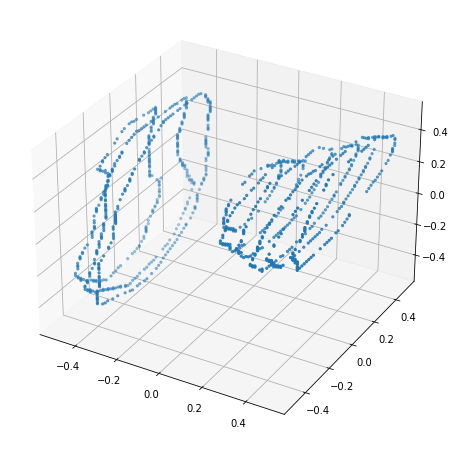

0, vol: 1, c: 1267
num_slices: 1, drop: [92, 93]
pc shape: (3, 1024), vol shape: (8, 213, 302)
-0.5 0.5000000000000002


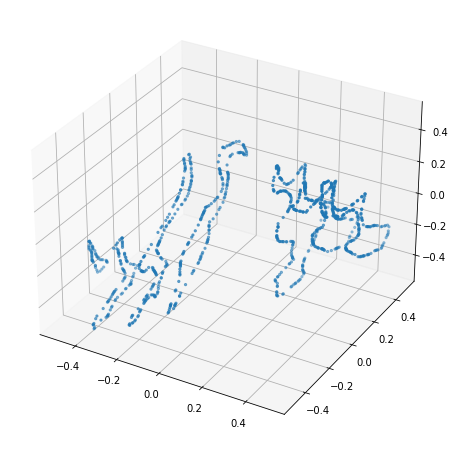

1, vol: 1, c: 54
num_slices: 2, drop: [5, 7]
pc shape: (3, 1024), vol shape: (13, 125, 255)
-0.5 0.5000000000000001


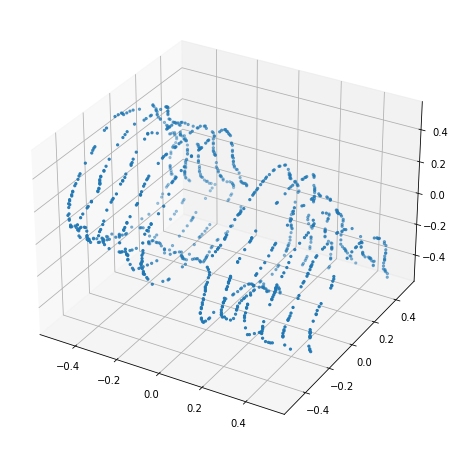

1, vol: 0, c: 236
num_slices: 2, drop: [91, 93]
pc shape: (3, 1024), vol shape: (14, 103, 105)
-0.5 0.5


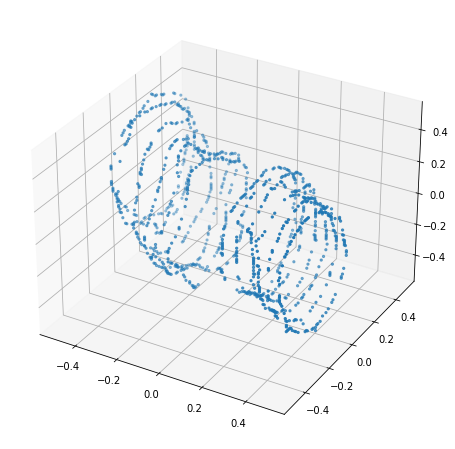

0, vol: 1, c: 1314
num_slices: 2, drop: [103, 105]
pc shape: (3, 1024), vol shape: (12, 100, 276)
-0.5 0.5


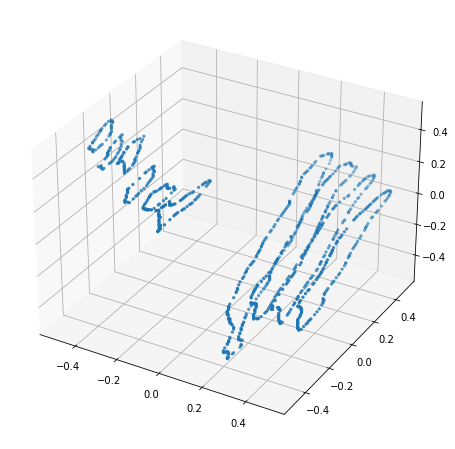

0, vol: 2, c: 1885
num_slices: 3, drop: [99, 102]
pc shape: (3, 1024), vol shape: (13, 305, 448)
-0.5 0.5


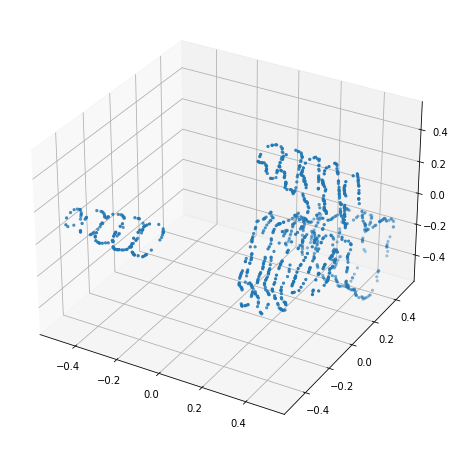

0, vol: 2, c: 224
num_slices: 2, drop: [8, 10]
pc shape: (3, 1024), vol shape: (14, 156, 179)
-0.5 0.5000000000000001


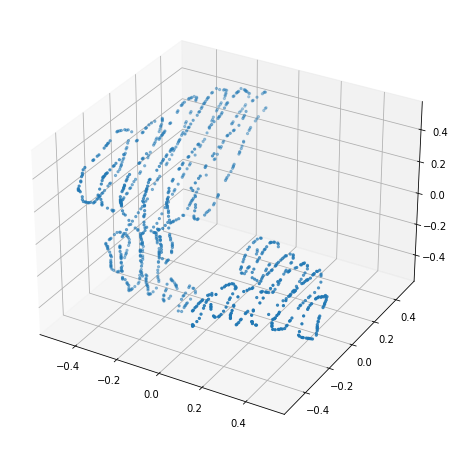

1, vol: 2, c: 1390
num_slices: 4, drop: [87, 91]
pc shape: (3, 1024), vol shape: (16, 73, 200)
-0.5 0.5


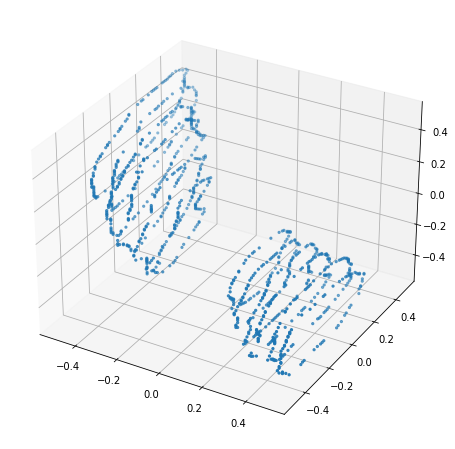

0, vol: 2, c: 417
num_slices: 2, drop: [15, 17]
pc shape: (3, 1024), vol shape: (12, 155, 221)
-0.5 0.5000000000000001


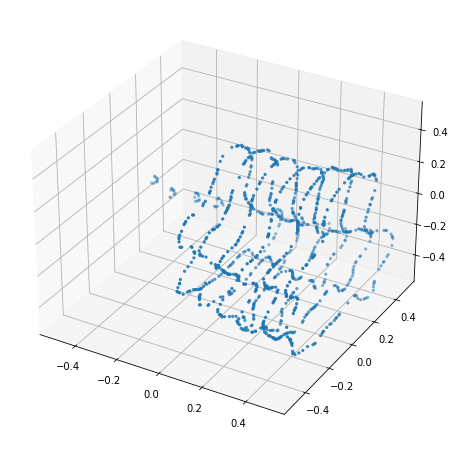

1, vol: 2, c: 1866
num_slices: 3, drop: [95, 98]
pc shape: (3, 1024), vol shape: (11, 233, 259)
-0.5 0.5


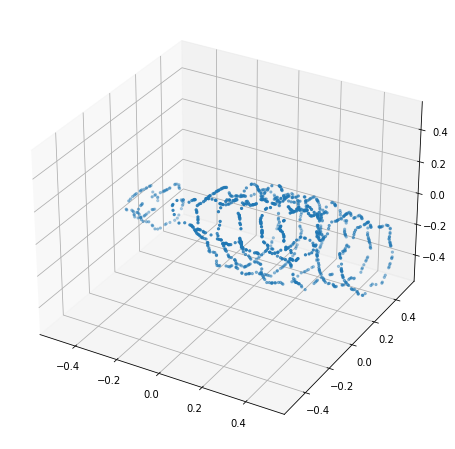

0, vol: 0, c: 275
num_slices: 3, drop: [34, 37]
pc shape: (3, 1024), vol shape: (15, 94, 195)
-0.5 0.5


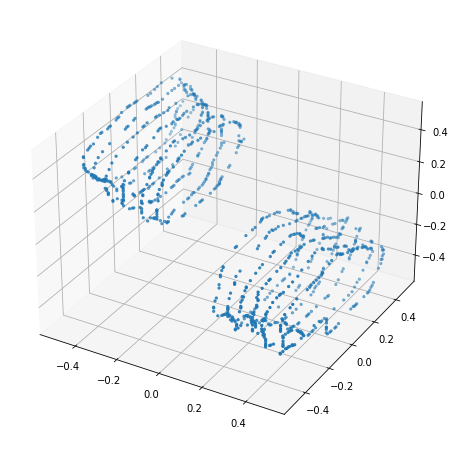

0, vol: 1, c: 1243
num_slices: 2, drop: [88, 90]
pc shape: (3, 1024), vol shape: (9, 119, 486)
-0.5 0.5000000000000002


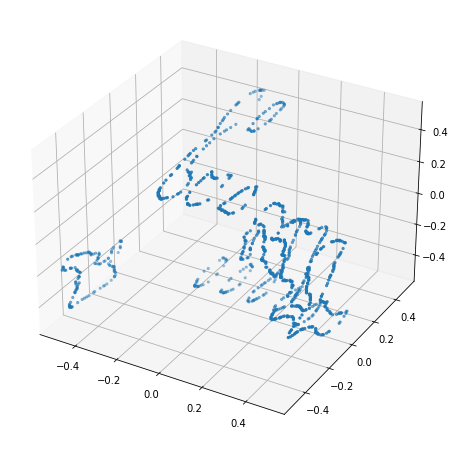

1, vol: 1, c: 1180
num_slices: 3, drop: [84, 87]
not enough points, need 1024, have 366, replace sampling to fix
pc shape: (3, 1024), vol shape: (11, 24, 88)
-0.5 0.5


KeyboardInterrupt: 

In [14]:
from proofreader.utils.vis import plot_3d
num = 20
for i in range(0, num):
    rand_i = random.randint(0, len(dataset))
    pc, vol, label = dataset[rand_i]
    pc = np.swapaxes(pc, 0, 1)
    plot_3d(pc)

